# LSTM with base stock market data

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import importlib
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import os
import sys
import numpy as np
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

import src.preprocess_data as preprocess_data

importlib.reload(preprocess_data)

# Set seeds for reproducibility
np.random.seed(0)
torch.manual_seed(0)

# Set PyTorch device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [13]:
DATA_PATH = "../data/processed/stocks.csv"

FOCUS_PRICE = "Close"
FOCUS_STOCK = "AAPL"

WINDOW_SIZE = 3
BATCH_SIZE = 16
LEARNING_RATE = 0.001
EPOCHS = 1000

LSTM_HIDDEN_SIZE = 2
LSTM_NUM_LAYERS = 1

## Data Preparation

### Processing

In [6]:
df_stocks = pd.read_csv(DATA_PATH)

# TODO: Expand this or use tweets from a larger period of time
# df_stocks = df_stocks[df_stocks["Name"] == FOCUS_STOCK]
df_stocks = df_stocks[:1000]

df_stocks = df_stocks[["Date", FOCUS_PRICE]]
df_stocks["Date"] = df_stocks["Date"].apply(preprocess_data.convert_date)

df_stocks.set_index("Date", inplace=True)

df_stocks = preprocess_data.apply_time_window(df = df_stocks,
                                              price_col_name=FOCUS_PRICE,
                                              n = WINDOW_SIZE)

print(len(df_stocks))
display(df_stocks.head(10))

997


,Close,Close-3,Close-2,Close-1
Date,,,,
2009-04-09,24.750000,23.150000,22.549999,22.799999
2009-04-13,26.850000,22.549999,22.799999,24.750000
2009-04-14,24.350000,22.799999,24.750000,26.850000
2009-04-15,24.150000,24.750000,26.850000,24.350000
2009-04-16,24.000000,26.850000,24.350000,24.150000
2009-04-17,24.750000,24.350000,24.150000,24.000000
2009-04-20,25.000000,24.150000,24.000000,24.750000
2009-04-21,25.799999,24.000000,24.750000,25.000000
2009-04-22,26.500000,24.750000,25.000000,25.799999


### Conversion to PyTorch, data splitting

In [7]:
Xy = df_stocks.to_numpy()
X = Xy[:, 1:]
X = np.expand_dims(X, axis=-1)

y = Xy[:, :1]

print(X.shape, y.shape)

(997, 3, 1) (997, 1)


In [8]:
split = int(len(X) * 0.8)

X_train, y_train = X[:split], y[:split]
X_test, y_test = X[split:], y[split:]

X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

torch.Size([797, 3, 1]) torch.Size([797, 1])
torch.Size([200, 3, 1]) torch.Size([200, 1])


### Dataset and DataLoaders

In [9]:
class StockDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
        self.len = len(X)

    def __len__(self):
        return self.len
    
    def __getitem__(self, i):
        return self.X[i], self.y[i]

In [10]:
train_dataset = StockDataset(X_train, y_train)
test_dataset = StockDataset(X_test, y_test)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

## Modelling

### Model

In [11]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super().__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size=input_size,
                            hidden_size=hidden_size,
                            num_layers=num_layers,
                            batch_first=True)
        
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        batch_size = x.size(0)

        h_0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device)
        c_0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device)

        x, _ = self.lstm(x, (h_0, c_0))
        x = self.fc(x[:, -1, :])
        
        return x

### Training

In [15]:
model = LSTM(input_size=1,
             hidden_size=LSTM_HIDDEN_SIZE,
             num_layers=LSTM_NUM_LAYERS).to(device)

loss = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),
                             lr=LEARNING_RATE)

for epoch in range(EPOCHS):
    model.train(True)

    train_loss = 0
    cnt = 0
    for i, batch in enumerate(train_dataloader):
        X, y = batch[0].to(device), batch[1].to(device)

        out = model(X)
        l = loss(out, y)
        train_loss += l

        optimizer.zero_grad()
        l.backward()
        optimizer.step()

        cnt += 1

    train_loss /= cnt

    model.train(False)

    val_loss = 0
    cnt = 0
    for i, batch in enumerate(test_dataloader):
        X, y = batch[0].to(device), batch[1].to(device)

        with torch.no_grad():
            out = model(X)
            l = loss(out, y)

            val_loss += l

        cnt += 1

    val_loss /= cnt

    if epoch % 100 == 0:
        print(f"[ Epoch {epoch} / {EPOCHS} ] Train loss = {train_loss} Val loss = {val_loss}")

[ Epoch 0 / 1000 ] Train loss = 232.1519775390625 Val loss = 46.89017105102539
[ Epoch 100 / 1000 ] Train loss = 51.830013275146484 Val loss = 0.8668016195297241
[ Epoch 200 / 1000 ] Train loss = 12.523987770080566 Val loss = 0.4925445318222046
[ Epoch 300 / 1000 ] Train loss = 3.753842353820801 Val loss = 0.5209600925445557
[ Epoch 400 / 1000 ] Train loss = 3.0427980422973633 Val loss = 0.5738399028778076
[ Epoch 500 / 1000 ] Train loss = 2.912663459777832 Val loss = 0.5446692705154419
[ Epoch 600 / 1000 ] Train loss = 2.889510154724121 Val loss = 0.5333665609359741
[ Epoch 700 / 1000 ] Train loss = 2.8857505321502686 Val loss = 0.5472115278244019
[ Epoch 800 / 1000 ] Train loss = 2.8631255626678467 Val loss = 0.49192240834236145
[ Epoch 900 / 1000 ] Train loss = 2.933910608291626 Val loss = 0.4953416585922241


## Evaluation

Text(0.5, 1.0, 'Test data')

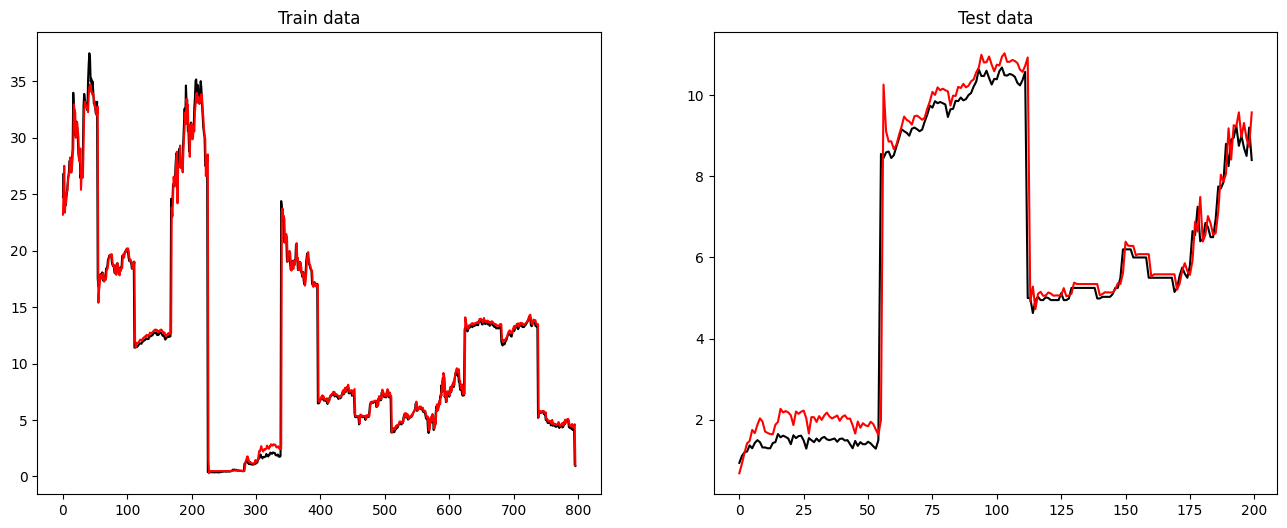

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

with torch.no_grad():
    y_pred = model(X_train.to(device)).to("cpu")
    y_pred = np.array(y_pred)

ax[0].plot(y_train, color="black", label = "True")
ax[0].plot(y_pred, color="red", label = "Predicted")
ax[0].set_title("Train data")

with torch.no_grad():
    y_pred = model(X_test.to(device)).to("cpu")
    y_pred = np.array(y_pred)

ax[1].plot(y_test, color="black", label = "True")
ax[1].plot(y_pred, color="red", label = "Predicted")
ax[1].set_title("Test data")
